The Taylor Series expansion of any smooth function $f(x)$ may be written as
\begin{equation}
    f(a + \Delta x) \cong f(a) + g \cdot (\Delta x) + \frac{1}{2}(\Delta x)^T H^{-1}(\Delta x) + \cdots
\end{equation}
where the gradient vector $g$ is evaluated at $x = a$ and $H^{-1} \equiv G$ is the Hessian matrix, i.e. the matrix of second derivatives
\begin{equation}
    G_{ij} = \frac{\partial^2 f}{\partial x_i \partial x_j}.
\end{equation}
Finding a point where $g$ vanishes is similar to the Newton-Raphson method for a system of equations, and if $H$ were known and $f(x)$ were a quadratic function, then the point could be found in a single step. However the matrix $H$ requires that the second derivatives are calculated which may be time-consuming or hard, especially for large $N$. The DFP algorithm is a technique that extends the steepest descent method by forming a suitable $H$-matrix as the calculation proceeds. It can be shown that $H^{-1}$ converges to the Hessian.

The search direction is taken as $s = -Hg$, where $H$ is taken initially as the identity matrix. At each stage, $\phi(\lambda)$ is minimised by choosing a value $\lambda^*$ as before, but then H is modified by replacing it with
\begin{equation}
    H^* = H - \frac{Hpp^TH}{p^THp} + \frac{qq^T}{p^Tq},
\end{equation}
where $p$ and $q$ are column vectors giving the changes in $g$ and $x$ respectively during the step, that is
\begin{equation}
    p = g(x_0 + \lambda^* s) - g(x_0), \quad q = \lambda^* s.
\end{equation}
Note that $H^*p = q$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def bedpan_function(x, y):
    return x + y + (x**2 / 4) - y**2 + (y**2 - x / 2)**2

def bedpan_gradient(x, y):
    df_dx = 1 + x / 2 - (y**2 - x / 2)
    df_dy = 1 - 2 * y + 2 * (y**2 - x / 2) * (2 * y)
    return np.array([df_dx, df_dy])

def rosenbrock_like_function(x, y):
    return (1 - x)**2 + 80 * (y - x**2)**2

def rosenbrock_like_gradient(x, y):
    df_dx = -2 * (1 - x) - 320 * x * (y - x**2)
    df_dy = 160 * (y - x**2)
    return np.array([df_dx, df_dy])

In [7]:
def dfp_algorithm(func, grad_func, x0, num_iterations=10):
    '''
    Performs the DFP (Davidon-Fletcher-Powell) algorithm.
    '''
    points_history = [x0]
    f_history = [func(x0[0], x0[1])]

    x_current = np.array(x0, dtype=float)

    # Initialize H as the identity matrix for N=2 variables
    H_current = np.identity(2)

    print(f"Starting at x_0 = {x_current}, f(x_0) = {f_history[0]:.6f}")
    print(f"Initial H_0:\n{H_current}")

    for i in range(num_iterations):
        g_current = grad_func(x_current[0], x_current[1])
        s_current = -H_current @ g_current # Matrix-vector product

        print(f"\n--- Iteration {i+1} ---")

        # Perform Line Search ---
        phi = lambda lam: func(x_current[0] + lam * s_current[0], x_current[1] + lam * s_current[1])

        lambda_range = 0.1 if func.__name__ == 'rosenbrock_like_function' else 1.0
        lambda_vals = np.linspace(0, lambda_range, 400)
        phi_vals = [phi(l) for l in lambda_vals]

        plt.figure(figsize=(8, 6))
        plt.plot(lambda_vals, phi_vals)
        plt.title(f"Iteration {i+1}: Plot of $\\phi(\\lambda)$")
        plt.xlabel(f"$\\lambda$ (Step Size)")
        plt.ylabel(f"$\\phi(\\lambda) = f({x_current} + \\lambda s)$")
        plt.grid(True)
        plt.show()
        time.sleep(1)

        while True:
            try:
                lambda_star_str = input(
                    f"Examine the plot above. Enter the value of λ* for iteration {i+1}: \n"
                )
                lambda_star = float(lambda_star_str)
                break
            except ValueError:
                print("Invalid input. Please enter a number.")

        # Update position and calculate p and q vectors
        x_next = x_current + lambda_star * s_current

        q = x_next - x_current

        g_next = grad_func(x_next[0], x_next[1])
        p = g_next - g_current

        # Update the H matrix using the DFP formula
        # Ensure p and q are treated as column vectors
        p = p.reshape(-1, 1) # Shape (2, 1)
        q = q.reshape(-1, 1) # Shape (2, 1)

        H_p = H_current @ p
        p_H_p = p.T @ H_p

        # Check for division by zero, which can happen if p is zero (already at minimum)
        if np.isclose(p_H_p, 0):
            print("Gradient change is near zero. Stopping update.")
            H_next = H_current
        else:
            term1 = (H_p @ H_p.T) / p_H_p
            term2 = (q @ q.T) / (p.T @ q)
            H_next = H_current - term1 + term2

        # Store results and print information ---
        points_history.append(x_next)
        f_current_val = f_history[-1]
        f_next_val = func(x_next[0], x_next[1])
        f_history.append(f_next_val)
        decrease = f_current_val - f_next_val

        print(f"  Selected λ* = {lambda_star}")
        print(f"  New Point (x, y) = ({x_next[0]:.6f}, {x_next[1]:.6f})")
        print(f"  Current Value f(x_{i+1}) = {f_next_val:.6f}")
        print(f"  Decrease from last step = {decrease:.6f}")
        print(f"  Updated H_{i+1}:\n{H_next}")

        # Prepare for next iteration ---
        x_current = x_next
        H_current = H_next

    return np.array(points_history), np.array(f_history)

def plot_optimization_path(func, points_history, f_values, title):
    x_coords = points_history[:, 0]
    y_coords = points_history[:, 1]
    x_buffer = (max(x_coords) - min(x_coords)) * 0.15 or 1.0
    y_buffer = (max(y_coords) - min(y_coords)) * 0.15 or 1.0
    x_range = np.linspace(min(x_coords) - x_buffer, max(x_coords) + x_buffer, 400)
    y_range = np.linspace(min(y_coords) - y_buffer, max(y_coords) + y_buffer, 400)
    X, Y = np.meshgrid(x_range, y_range)
    Z = func(X, Y)
    plt.figure(figsize=(10, 8))
    if func.__name__ == 'rosenbrock_like_function':
        custom_levels = np.array([0.1, 0.5, 1, 2, 5, 10, 20, 50, 100])
    else:
        min_f_val = f_values[-1] if len(f_values) > 0 else 0
        fine_levels = np.linspace(min_f_val, min_f_val + 0.5, 20)
        coarse_levels = np.logspace(0, 3, 20)
        custom_levels = np.sort(np.concatenate([fine_levels, coarse_levels]))
    plt.contour(X, Y, Z, levels=custom_levels, cmap='viridis')
    plt.plot(x_coords, y_coords, 'r-o', label='Iteration Path')
    plt.plot(x_coords[0], y_coords[0], 'go', markersize=10, label='Start Point')
    plt.plot(x_coords[-1], y_coords[-1], 'bo', markersize=10, label='End Point')
    plt.title(title)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$y$')
    plt.legend()
    plt.grid(True)
    plt.colorbar(label=f'$f(x, y)$')
    plt.show()

Starting at x_0 = [-1.  -1.3], f(x_0) = 1.056100
Initial H_0:
[[1. 0.]
 [0. 1.]]

--- Iteration 1 ---


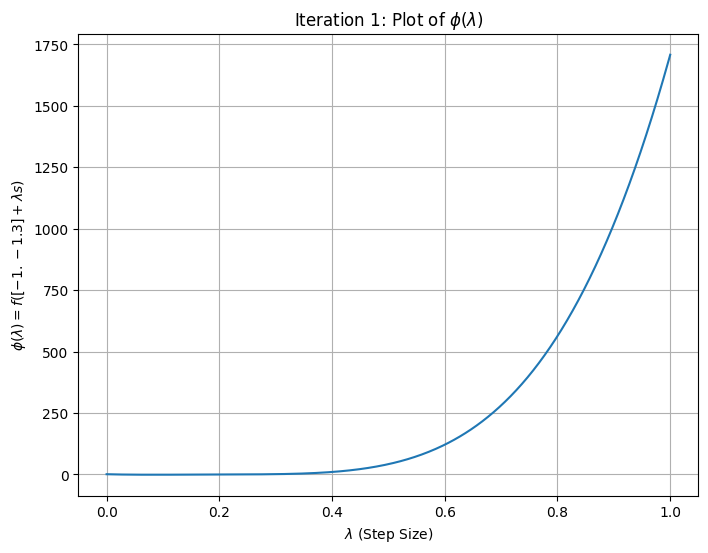

Examine the plot above. Enter the value of λ* for iteration 1: 
0.01
  Selected λ* = 0.01
  New Point (x, y) = (-0.983100, -1.222120)
  Current Value f(x_1) = 0.483554
  Decrease from last step = 0.572546
  Updated H_1:
[[ 0.98321107 -0.12620625]
 [-0.12620625  0.0685888 ]]

--- Iteration 2 ---


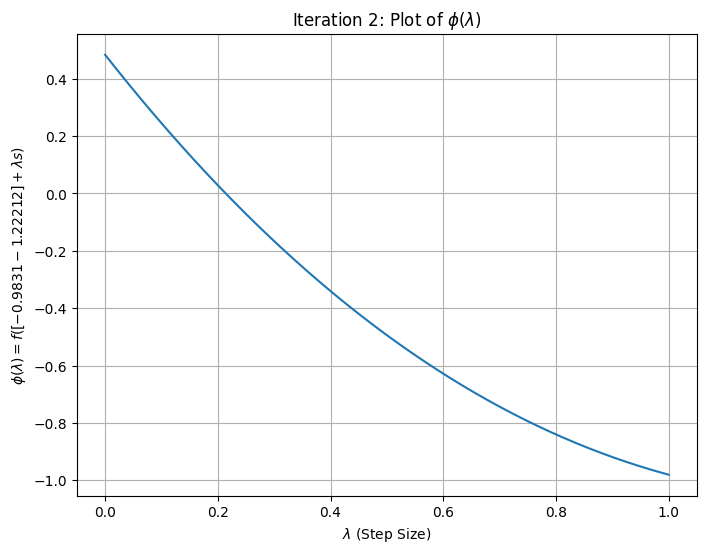

Examine the plot above. Enter the value of λ* for iteration 2: 
1.5
  Selected λ* = 1.5
  New Point (x, y) = (0.009649, -0.857618)
  Current Value f(x_2) = -1.049555
  Decrease from last step = 1.533110
  Updated H_2:
[[ 0.95307084 -0.10448902]
 [-0.10448902  0.08463005]]

--- Iteration 3 ---


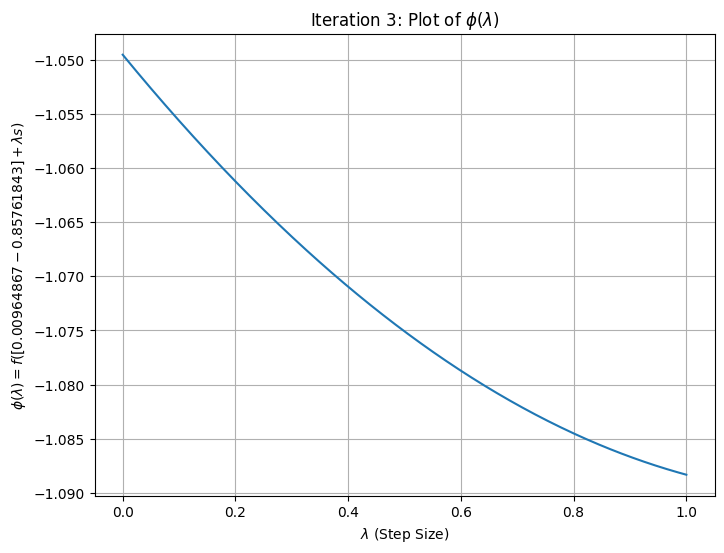

Examine the plot above. Enter the value of λ* for iteration 3: 
1.0
  Selected λ* = 1.0
  New Point (x, y) = (-0.229825, -0.846631)
  Current Value f(x_3) = -1.088316
  Decrease from last step = 0.038761
  Updated H_3:
[[ 1.35516179 -0.17978052]
 [-0.17978052  0.08645839]]

--- Iteration 4 ---


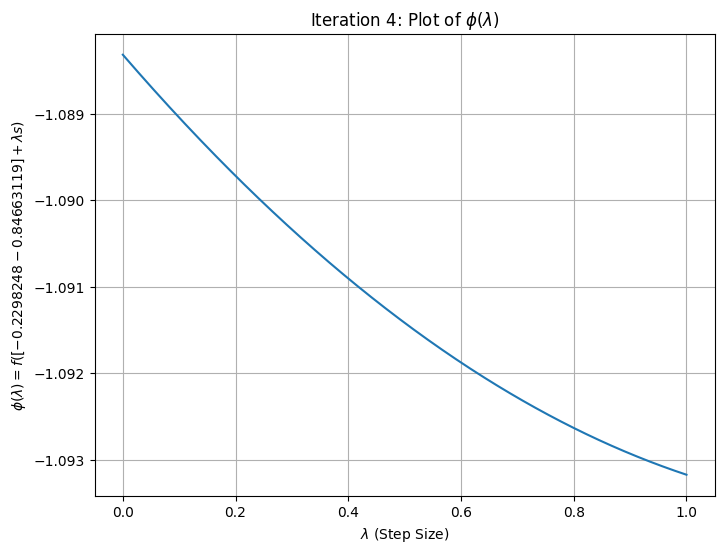

Examine the plot above. Enter the value of λ* for iteration 4: 
1.0
  Selected λ* = 1.0
  New Point (x, y) = (-0.324345, -0.826372)
  Current Value f(x_4) = -1.093176
  Decrease from last step = 0.004860
  Updated H_4:
[[ 1.66612708 -0.37515834]
 [-0.37515834  0.14364768]]

--- Iteration 5 ---


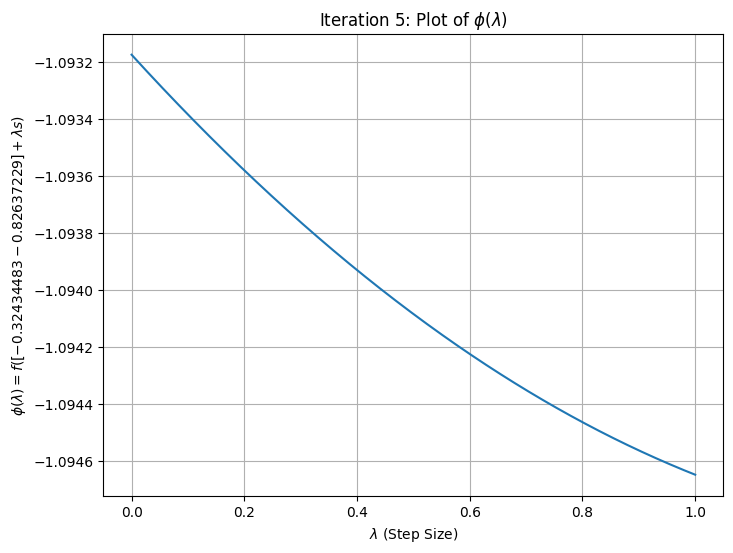

Examine the plot above. Enter the value of λ* for iteration 5: 
1.0
  Selected λ* = 1.0
  New Point (x, y) = (-0.365037, -0.808890)
  Current Value f(x_5) = -1.094647
  Decrease from last step = 0.001471
  Updated H_5:
[[ 1.43577667 -0.45894402]
 [-0.45894402  0.23479976]]

--- Iteration 6 ---


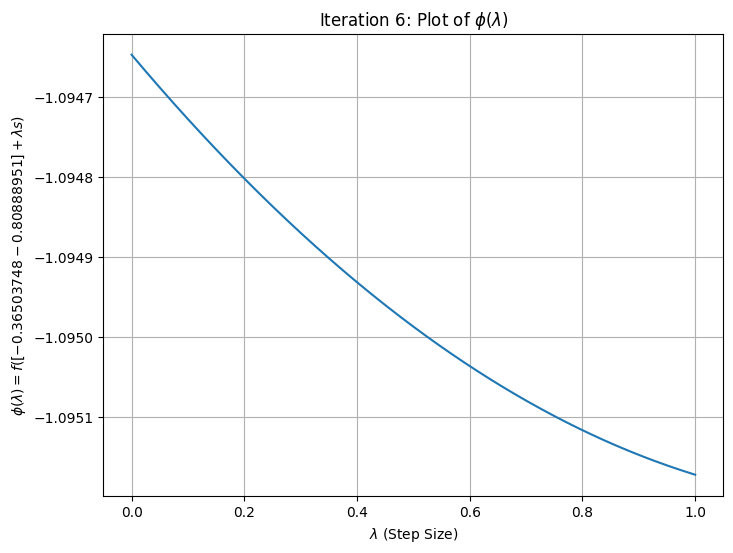

Examine the plot above. Enter the value of λ* for iteration 6: 
1.0
  Selected λ* = 1.0
  New Point (x, y) = (-0.378485, -0.796679)
  Current Value f(x_6) = -1.095172
  Decrease from last step = 0.000525
  Updated H_6:
[[ 1.11888768 -0.35369137]
 [-0.35369137  0.25023446]]

--- Iteration 7 ---


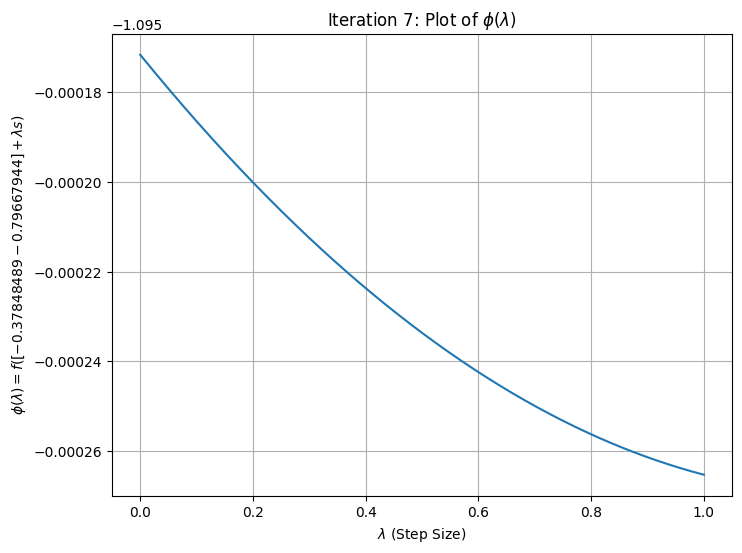

Examine the plot above. Enter the value of λ* for iteration 7: 
1.0
  Selected λ* = 1.0
  New Point (x, y) = (-0.375161, -0.793258)
  Current Value f(x_7) = -1.095265
  Decrease from last step = 0.000094
  Updated H_7:
[[ 1.20916486 -0.26969578]
 [-0.26969578  0.21451721]]

--- Iteration 8 ---


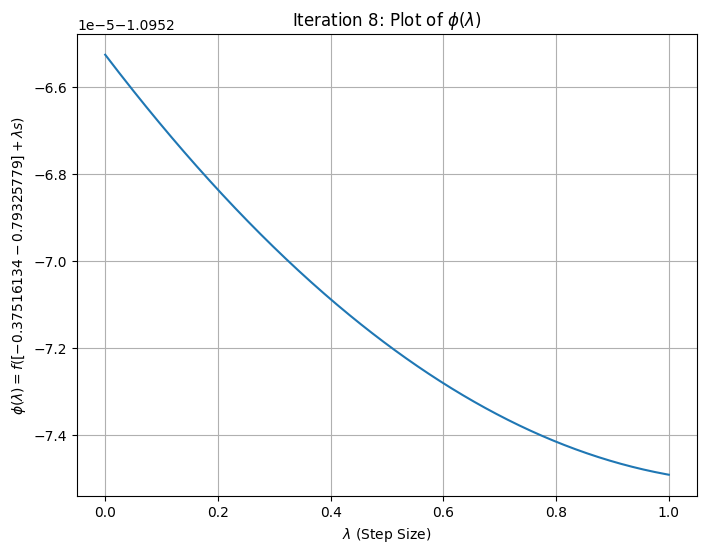

Examine the plot above. Enter the value of λ* for iteration 8: 
1.0
  Selected λ* = 1.0
  New Point (x, y) = (-0.371258, -0.793304)
  Current Value f(x_8) = -1.095275
  Decrease from last step = 0.000010
  Updated H_8:
[[ 1.53764013 -0.33645887]
 [-0.33645887  0.21050203]]

--- Iteration 9 ---


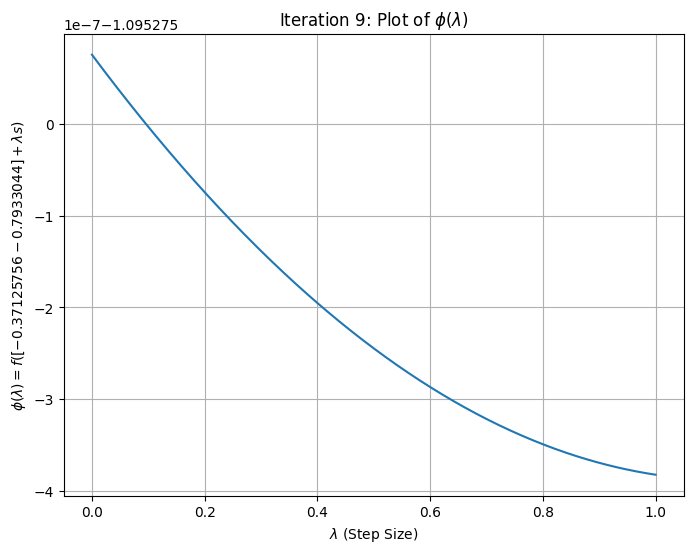

Examine the plot above. Enter the value of λ* for iteration 9: 
1.0
  Selected λ* = 1.0
  New Point (x, y) = (-0.370162, -0.793621)
  Current Value f(x_9) = -1.095275
  Decrease from last step = 0.000000
  Updated H_9:
[[ 1.66385824 -0.42633185]
 [-0.42633185  0.25002392]]

--- Iteration 10 ---


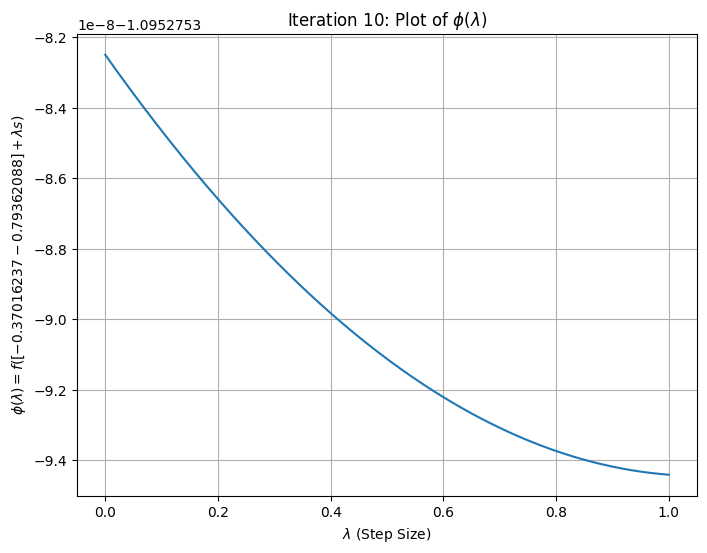

Examine the plot above. Enter the value of λ* for iteration 10: 
1.0
  Selected λ* = 1.0
  New Point (x, y) = (-0.370038, -0.793696)
  Current Value f(x_10) = -1.095275
  Decrease from last step = 0.000000
  Updated H_10:
[[ 1.60348533 -0.42127017]
 [-0.42127017  0.26457013]]

All iterations complete.


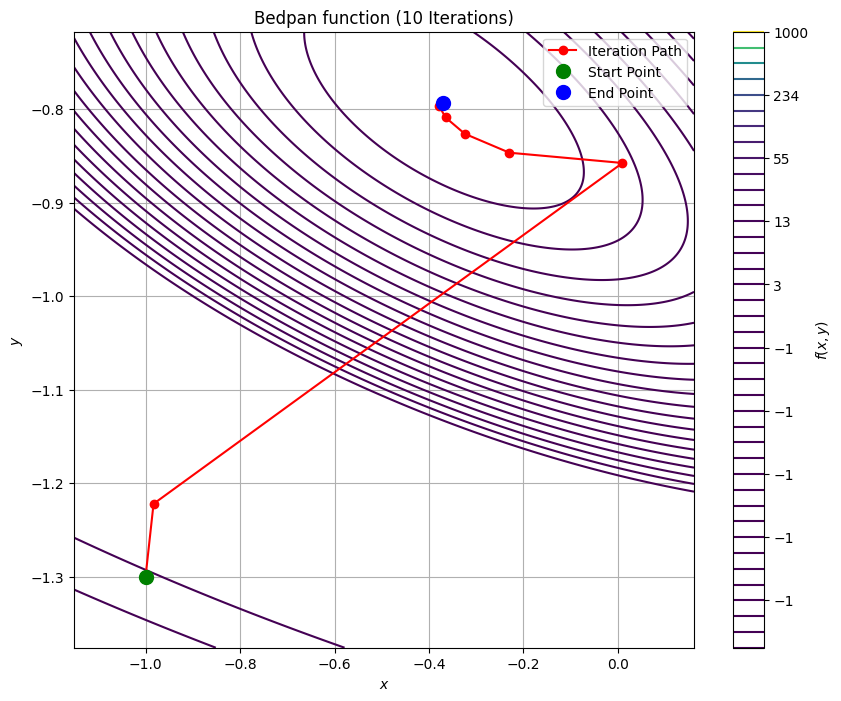

In [8]:
initial_point = np.array([-1.0, -1.3])
path_history, f_values = dfp_algorithm(
    bedpan_function,
    bedpan_gradient,
    initial_point,
    num_iterations = 10
)

print("\nAll iterations complete.")
plot_optimization_path(
    bedpan_function,
    path_history,
    f_values,
    title=f"Bedpan function ({10} Iterations)"
)

Starting at x_0 = [0.676 0.443], f(x_0) = 0.120602
Initial H_0:
[[1. 0.]
 [0. 1.]]

--- Iteration 1 ---


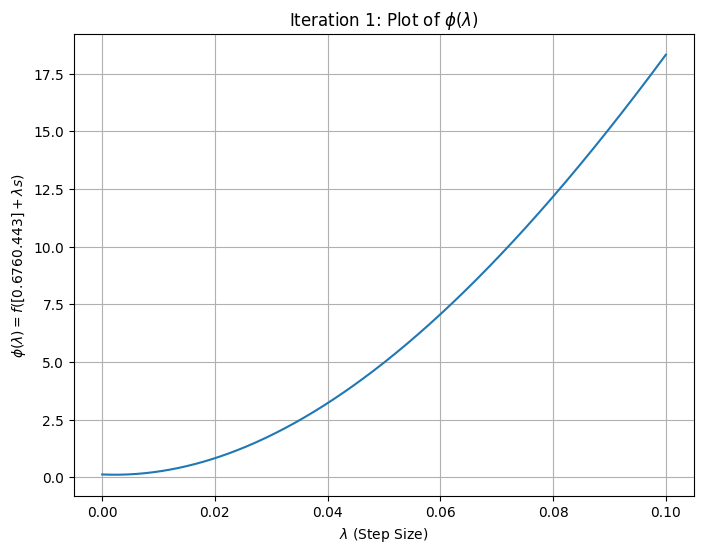

Examine the plot above. Enter the value of λ* for iteration 1: 
0.01
  Selected λ* = 0.01
  New Point (x, y) = (0.652247, 0.465362)
  Current Value f(x_1) = 0.248518
  Decrease from last step = -0.127916
  Updated H_1:
[[0.36504829 0.47995588]
 [0.47995588 0.63724625]]

--- Iteration 2 ---


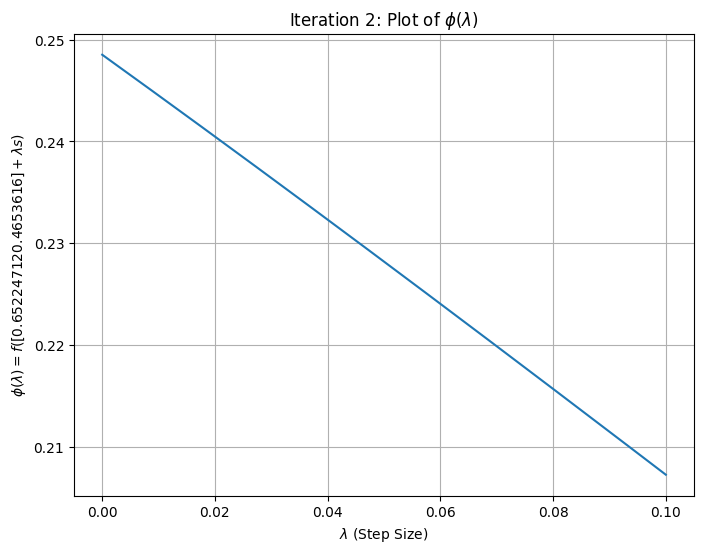

Examine the plot above. Enter the value of λ* for iteration 2: 
0.2
  Selected λ* = 0.2
  New Point (x, y) = (0.698230, 0.517879)
  Current Value f(x_2) = 0.164774
  Decrease from last step = 0.083745
  Updated H_2:
[[-0.35248208 -0.40825599]
 [-0.40825599 -0.47237153]]

--- Iteration 3 ---


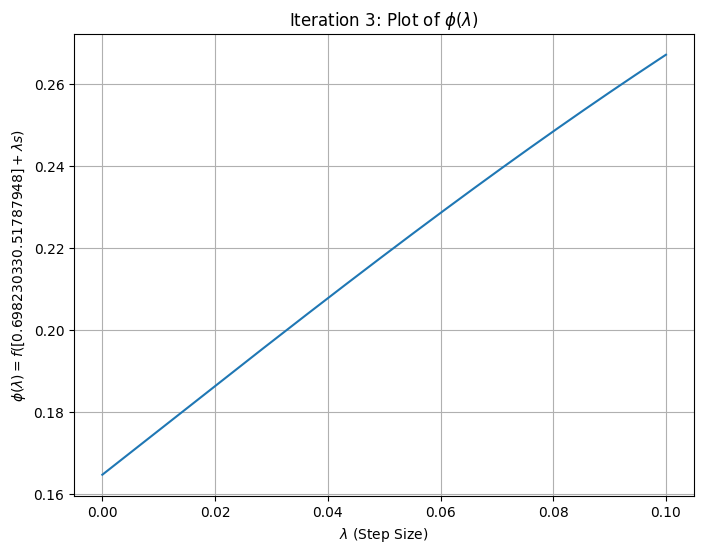

Examine the plot above. Enter the value of λ* for iteration 3: 
0.001
  Selected λ* = 0.001
  New Point (x, y) = (0.697610, 0.517158)
  Current Value f(x_3) = 0.165855
  Decrease from last step = -0.001081
  Updated H_3:
[[-0.15626123 -0.21253167]
 [-0.21253167 -0.28377056]]

--- Iteration 4 ---


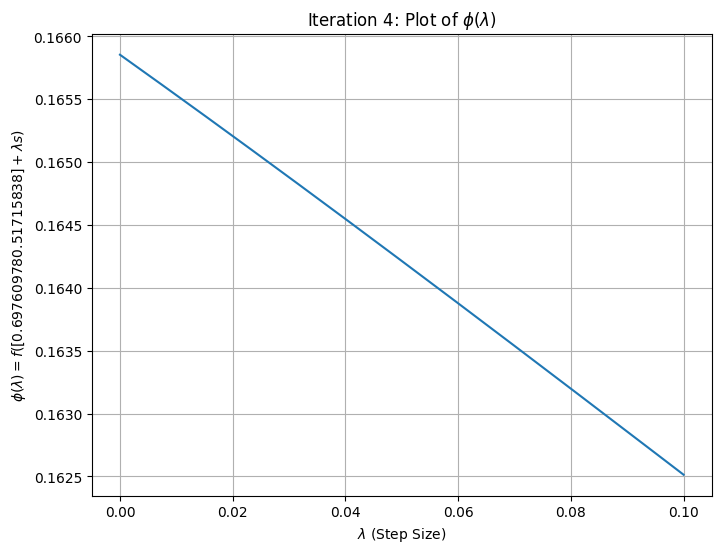

Examine the plot above. Enter the value of λ* for iteration 4: 
0.1
  Selected λ* = 0.1
  New Point (x, y) = (0.685482, 0.498079)
  Current Value f(x_4) = 0.162514
  Decrease from last step = 0.003341
  Updated H_4:
[[-0.47703857 -0.74284654]
 [-0.74284654 -1.15623957]]

--- Iteration 5 ---


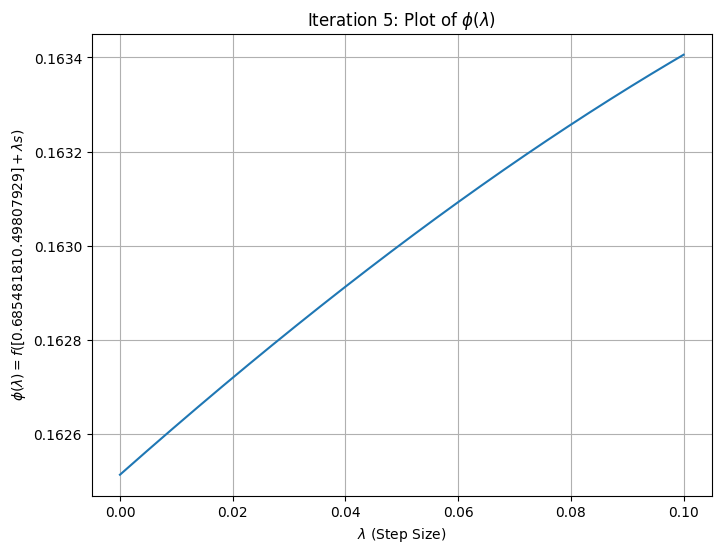

Examine the plot above. Enter the value of λ* for iteration 5: 
0.001
  Selected λ* = 0.001
  New Point (x, y) = (0.685583, 0.498234)
  Current Value f(x_5) = 0.162524
  Decrease from last step = -0.000011
  Updated H_5:
[[-0.26965084 -0.40406906]
 [-0.40406906 -0.60413978]]

--- Iteration 6 ---


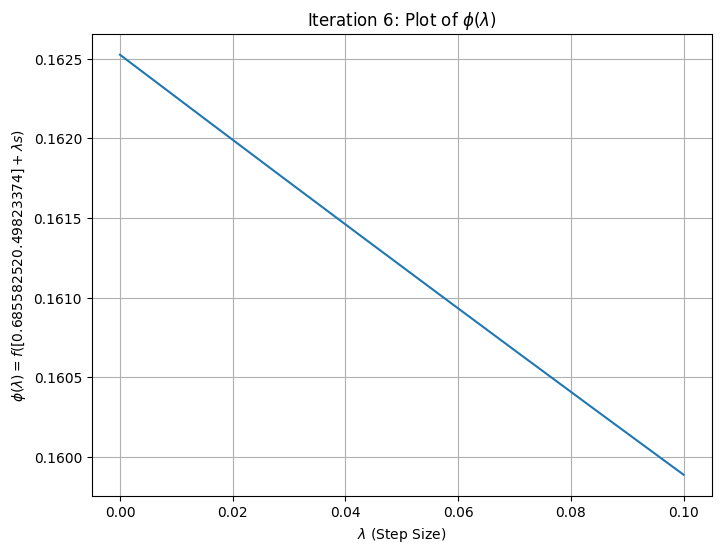

Examine the plot above. Enter the value of λ* for iteration 6: 
0.1
  Selected λ* = 0.1
  New Point (x, y) = (0.684123, 0.495435)
  Current Value f(x_6) = 0.159889
  Decrease from last step = 0.002635
  Updated H_6:
[[-0.51282225 -0.73139847]
 [-0.73139847 -1.03753207]]

--- Iteration 7 ---


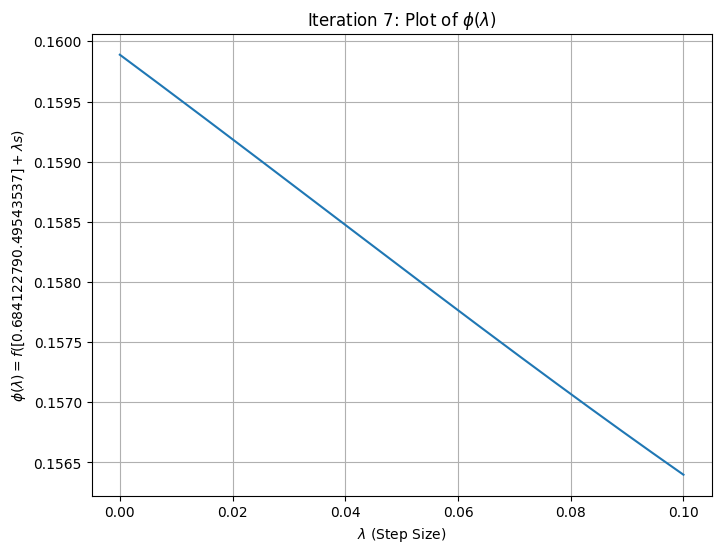

Examine the plot above. Enter the value of λ* for iteration 7: 
0.1
  Selected λ* = 0.1
  New Point (x, y) = (0.664765, 0.465368)
  Current Value f(x_7) = 0.156398
  Decrease from last step = 0.003491
  Updated H_7:
[[ 6.26204946  9.65331568]
 [ 9.65331568 14.8815072 ]]

--- Iteration 8 ---


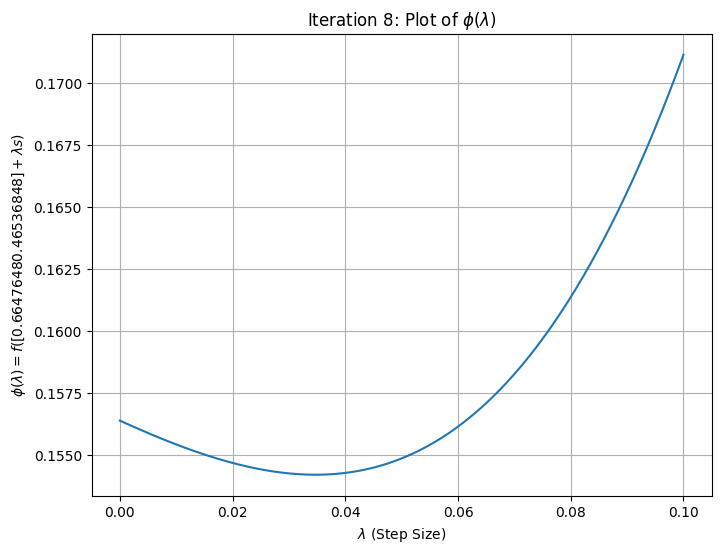

Examine the plot above. Enter the value of λ* for iteration 8: 
0.04
  Selected λ* = 0.04
  New Point (x, y) = (0.633386, 0.416943)
  Current Value f(x_8) = 0.154288
  Decrease from last step = 0.002110
  Updated H_8:
[[0.20701823 0.31680777]
 [0.31680777 0.48515239]]

--- Iteration 9 ---


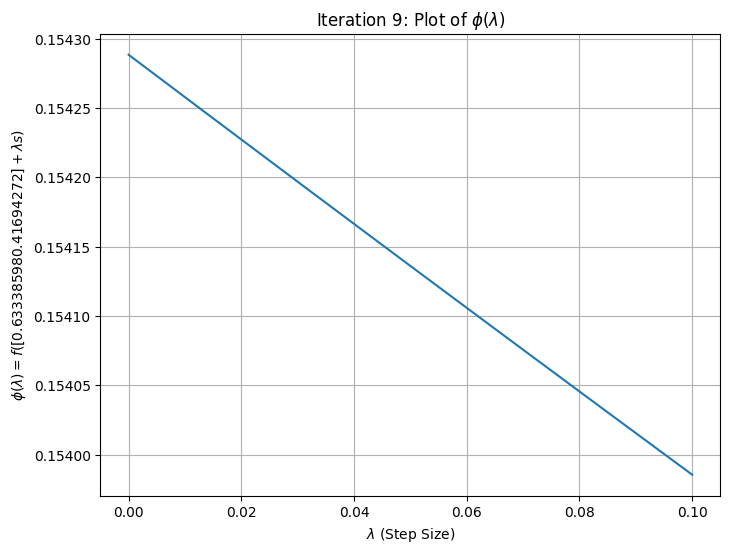

Examine the plot above. Enter the value of λ* for iteration 9: 
0.1
  Selected λ* = 0.1
  New Point (x, y) = (0.634802, 0.419027)
  Current Value f(x_9) = 0.153985
  Decrease from last step = 0.000303
  Updated H_9:
[[0.29427818 0.43186166]
 [0.43186166 0.63389568]]

--- Iteration 10 ---


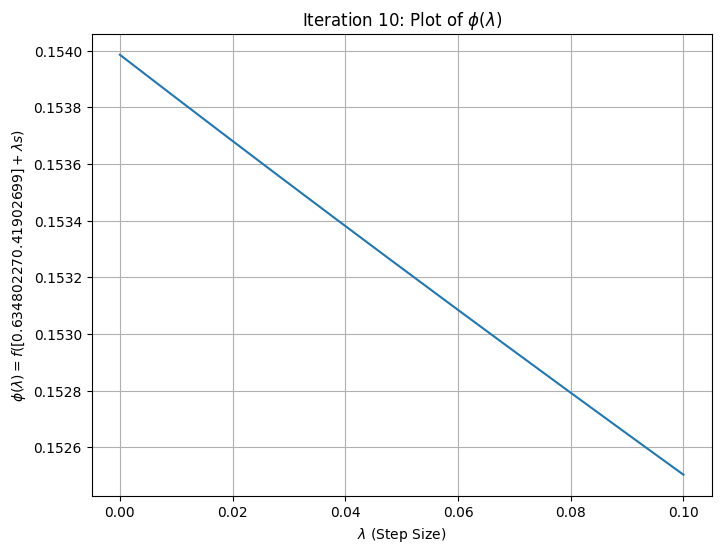

Examine the plot above. Enter the value of λ* for iteration 10: 
0.1
  Selected λ* = 0.1
  New Point (x, y) = (0.641336, 0.428583)
  Current Value f(x_10) = 0.152503
  Decrease from last step = 0.001482
  Updated H_10:
[[0.46731803 0.68208926]
 [0.68208926 0.9956655 ]]

All iterations complete.


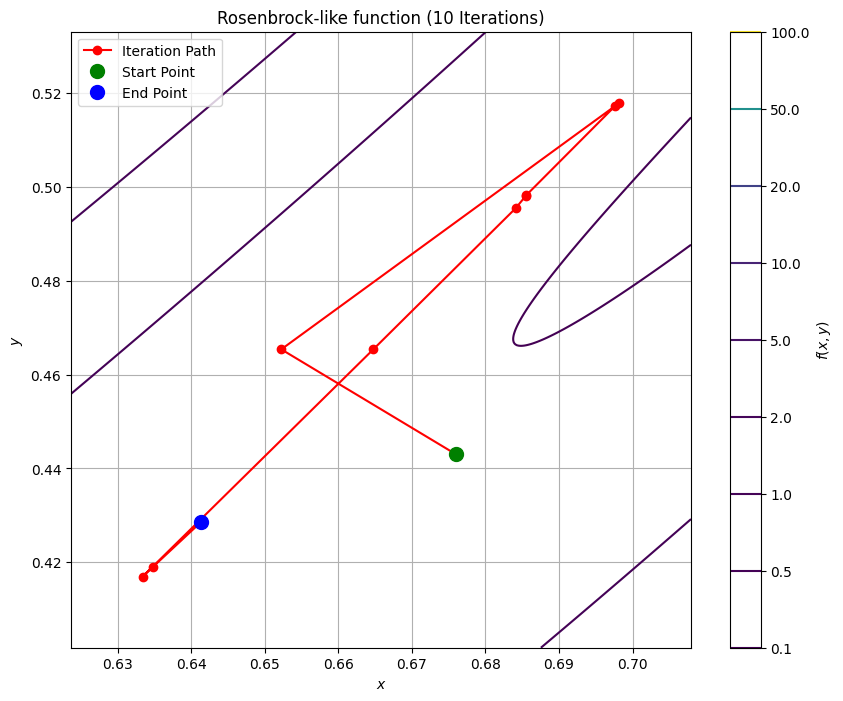

In [9]:
initial_point = np.array([0.676, 0.443])
path_history, f_values = dfp_algorithm(
    rosenbrock_like_function,
    rosenbrock_like_gradient,
    initial_point,
    num_iterations = 10
)

print("\nAll iterations complete.")
plot_optimization_path(
    rosenbrock_like_function,
    path_history,
    f_values,
    title=f"Rosenbrock-like function ({10} Iterations)"
)

The final $H$ matrix produced by the DFP algorithm is an excellent approximation of the true inverse Hessian at the minimum. The $H$ matrix has converged to an extremely accurate approximation of the true inverse Hessian at the minimum. The algorithm effectively tries to match $H$ to the curvature of the function and uses that information to take direct steps towards the minimum, avoiding the zigzagging of simpler methods.

*   Steepest Descents (SD) is the simplest but least effective method. Its reliance on the local gradient makes it fundamentally unsuited for problems with narrow valleys or ill-conditioned Hessians, where it becomes unacceptably slow.

*   Conjugate Gradients (CG) is a major improvement. By incorporating information from the previous search direction, it builds a more complete picture of the landscape, allowing it to avoid the simple zigzagging of SD and converge much more quickly, especially on difficult functions.

*   DFP is the most powerful of the three. By explicitly building an approximation of the inverse Hessian matrix, it takes into account the function's curvature. This allows it to scale the gradient and take steps that are analogous to the single step of Newton's method. As a result, it converges the fastest on both the simple and the complex problem, requiring the fewest iterations.

In summary, the DFP algorithm offers the fastest and most robust convergence at the cost of slightly higher computational complexity per step due to the matrix updates.